In [29]:
import os
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import *
import pandas as pd
import pathlib
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
import numpy as np
import seaborn as sns
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set(rc={'figure.figsize':(9, 7)})

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Coral Ordinal Function and Custom metric defining here
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
MODEL_PATH = '../data/models/'
DATA_DIR = '../data/'


In [30]:
DATA_DIR = '../data'

pd.set_option('display.max_columns', None)

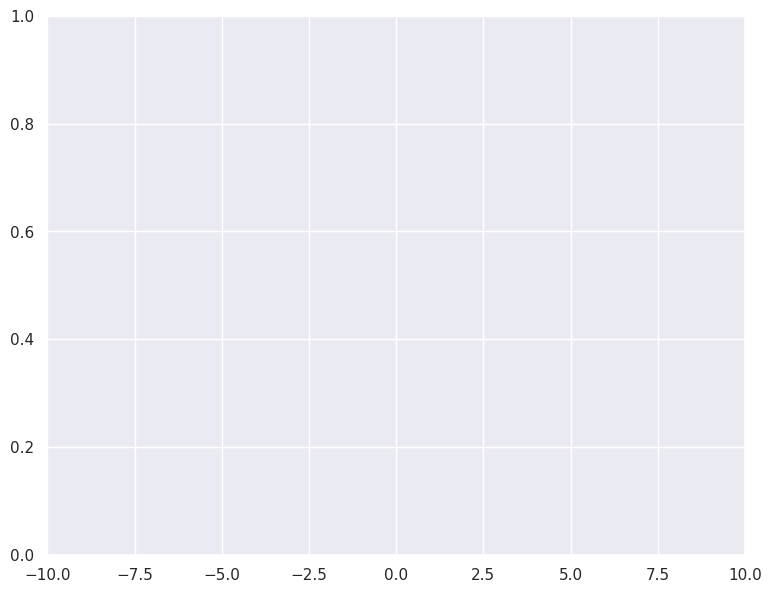

In [31]:


figure(figsize=(9, 7))

# Same range for all plots
# start = -0.5
# end = 0.5
n = 300

In [32]:
# import argparse
# # Create the parser
# parser = argparse.ArgumentParser(description="Script for generating the results")
# # Add the --value argument
# parser.add_argument('--dv', type=int, help="Data version")
# # Parse the arguments
# args = parser.parse_args()
# # Asking the user for their name
# data_type = int(args.dv)
num_features = 1
data_type = 4

In [33]:
data_version = ''
if data_type != 4:

    data_version = 'synthetic'

    path = f'../data/new_data/data{data_type}/'

    train_df = pd.read_csv(f'{path}/Data{data_type}_Train.csv')
    val_df = pd.read_csv(f'{path}/Data{data_type}_Val.csv')
    test_df = pd.read_csv(f'{path}/Data{data_type}_Test.csv')

else:
    data_version = 'household_power'
    path = f'../data/{data_version}/'

    feature_x = pd.read_csv(f'{path}/feature_x.csv')

    train_x = np.load(f'{path}/train_x.npy')
    train_y = np.load(f'{path}/train_y.npy')

    val_x = np.load(f'{path}/val_x.npy')
    val_y = np.load(f'{path}/val_y.npy')

    test_x = np.load(f'{path}/test_x.npy')
    test_y = np.load(f'{path}/test_y.npy')


In [34]:
# feature_x[:train_x.shape[0]].dt
feature_x[train_x.shape[0]+val_x.shape[0]:train_x.shape[0]+val_x.shape[0]+test_x.shape[0]][:100]


,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
26280,2009-12-15 17:00:00,1.158200,0.121067,243.461833,4.753333,0.000000,0.666667,1.183333
26281,2009-12-15 18:00:00,1.386200,0.112767,245.007500,5.680000,0.000000,0.000000,0.683333
26282,2009-12-15 19:00:00,1.694033,0.262667,245.273500,7.023333,0.000000,0.000000,0.666667
26283,2009-12-15 20:00:00,1.722467,0.150133,245.031667,7.033333,0.366667,0.666667,6.766667
26284,2009-12-15 21:00:00,2.486267,0.120500,245.004000,10.150000,9.033333,0.000000,11.816667
...,...,...,...,...,...,...,...,...
26375,2009-12-19 16:00:00,1.402967,0.062600,248.877333,5.586667,0.000000,0.200000,18.950000
26376,2009-12-19 17:00:00,1.395933,0.131467,243.945500,5.666667,0.000000,0.483333,18.233333
26377,2009-12-19 18:00:00,0.468100,0.049233,244.724333,1.890000,0.000000,0.000000,3.633333
26378,2009-12-19 19:00:00,1.456400,0.126100,244.302500,6.146667,0.000000,12.933333,0.000000


In [35]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((17520, 7), (17520,), (8760, 7), (8760,), (8308, 7), (8308,))

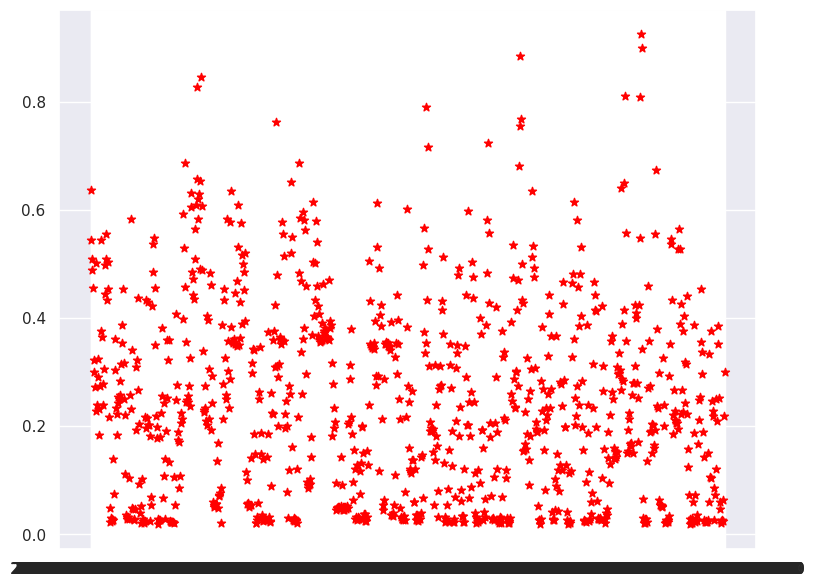

In [36]:

scatter(feature_x[:train_x.shape[0]].dt[:1000], train_y[:1000], c="red", marker="*")

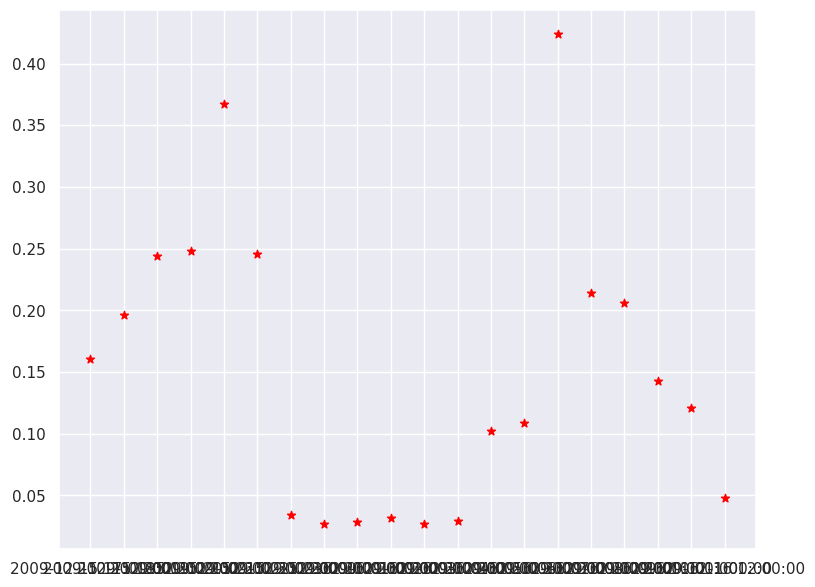

In [37]:
scatter(feature_x[train_x.shape[0]+val_x.shape[0]:train_x.shape[0]+val_x.shape[0]+test_x.shape[0]].dt[:20], test_y[:20], c="red", marker="*")


In [38]:
def get_mcdo_hyperparameters(data_type):
    hp_search_data_path =f'./hyperparameter_search/RAY_RESULTS_mcdo_data{data_type}.csv'
    hp_df = pd.read_csv(hp_search_data_path)

    hp_df = hp_df.sort_values('best_val_loss')
    hp_df.columns = hp_df.columns.str.replace('config/', '')

    return int(hp_df['batch_size'].iloc[0]), int(hp_df['hidden_size'].iloc[0]), int(hp_df['num_layers'].iloc[0]), hp_df['drop_out'].iloc[0], hp_df['lr'].iloc[0], int(hp_df['patience'].iloc[0]), hp_df['epochs'].iloc[0]

In [39]:
batch_size, hidden_size, num_layers, drop_out, learning_rate, patience, epochs =get_mcdo_hyperparameters(data_type)
print(batch_size, hidden_size, num_layers, drop_out, learning_rate, patience, epochs)

1 28 9 0.1645723382848516 0.000251462580127 27 500


In [40]:
tensor_train_data = torch.Tensor(train_x)
tensor_train_label = torch.Tensor(train_y)

tensor_val_data = torch.Tensor(val_x)
tensor_val_label = torch.Tensor(val_y)

tensor_test_data = torch.Tensor(test_x)
tensor_test_label = torch.Tensor(test_y)

In [41]:
tensor_train_data.shape, tensor_train_label.shape, tensor_val_data.shape, tensor_val_label.shape, tensor_test_data.shape, tensor_test_label.shape


(torch.Size([17520, 7]),
 torch.Size([17520]),
 torch.Size([8760, 7]),
 torch.Size([8760]),
 torch.Size([8308, 7]),
 torch.Size([8308]))

In [42]:
def normalize_values(x):
    max_x = torch.max(x,dim=0)
    min_x = torch.min(x,dim=0)

    # print(max_x.values, min_x.values)

    range_x = max_x.values - min_x.values
    # print(range_x)

    #Normalizing
    x = (x - min_x.values)/range_x

    return x

In [43]:
train_dataset = TensorDataset(tensor_train_data, tensor_train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(tensor_val_data, tensor_val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(tensor_test_data, tensor_test_label)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [44]:
num_features = 7

### Monte Carlo Dropout

In [45]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class MCDO(nn.Module):
    def __init__(self, num_features, hidden_size, n_layers, drop_out):
        super(MCDO, self).__init__()

        layers = []
        input_size = num_features

        # Create 'n' linear layers
        for _ in range(n_layers - 1):  # n_layers - 1 because the last layer is the output layer
            layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size

        # The last layer outputs a single value
        self.out = nn.Linear(hidden_size, 1)
        self.layers = nn.ModuleList(layers)
        self.dropout = nn.Dropout(p=drop_out)

    def forward(self, x):
        for layer in self.layers:
            x = self.dropout(torch.relu(layer(x)))
        out = self.out(x)  # Apply the output layer
        return out

model = MCDO(num_features, hidden_size, num_layers, drop_out)
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MCDO(
  (out): Linear(in_features=28, out_features=1, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=28, bias=True)
    (1-7): 7 x Linear(in_features=28, out_features=28, bias=True)
  )
  (dropout): Dropout(p=0.1645723382848516, inplace=False)
)
Params: 5937


In [46]:
feature_x['str_dt'] = feature_x.dt.str[5:-6]

In [50]:
def make_plot_mcdo(model, data_type, epoch, samples = 50):
    num_data_points = 40

    # Keep dropout active!
    model.train()
    preds = [model(tensor_test_data) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_test_data.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      temp['x'] = feature_x[train_x.shape[0]+val_x.shape[0]:train_x.shape[0]+val_x.shape[0]+test_x.shape[0]].str_dt.reset_index(drop=True)
      temp = temp[:num_data_points]
      dfs.append(temp)

    start = temp['x'].min()
    end = temp['x'].max()

    print(start,end)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # start = train_df.Input1.min()
    # end = train_df.Input1.max()

  # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    inp_x = feature_x[train_x.shape[0]+val_x.shape[0]:train_x.shape[0]+val_x.shape[0]+test_x.shape[0]].str_dt[:num_data_points]
    inp_y = test_y[:num_data_points]
    # Plot train data on top
    scatter(inp_x, inp_y, c="green", marker="*", alpha=0.4)

     # Remove x-axis labels and set custom numeric labels
    plt.xticks([])  # Remove x-axis labels
    # plt.gca().set_xticks(range(1, num_data_points*3 + 1))  # Set custom numeric labels
    # Rotate the X-axis tick labels by 30 degrees
    # plt.xticks(rotation=-60)

    op_dir = f'./results/{data_version}'
    pathlib.Path(op_dir).mkdir(parents=True, exist_ok=True) 

    output_path = f'{op_dir}/data{data_type}_mcdo_epoch{epoch}_{data_version}.png'
    plt.savefig(output_path)
    plt.show()

12-15 17 12-17 08


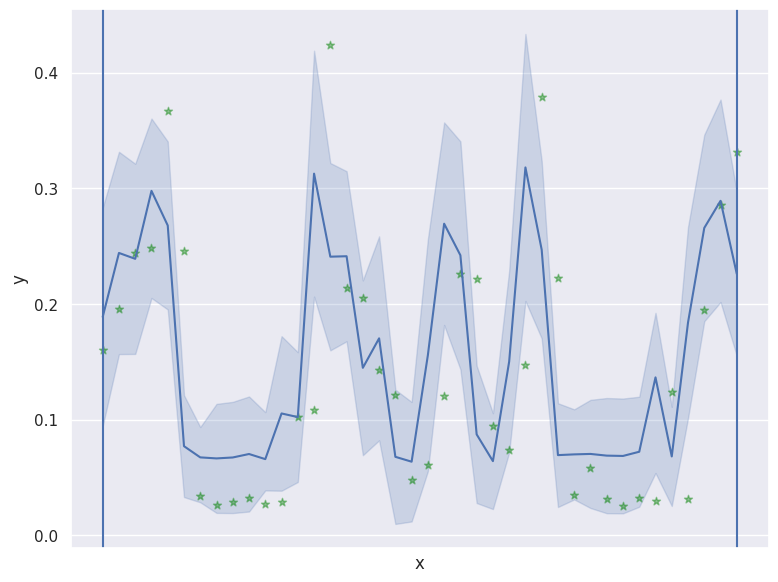

In [51]:
make_plot_mcdo(model, data_type, epoch,50)

Epoch: 0|Train Loss: 0.002611592411994934|Val Loss: 0.008803897158448483
Epoch 0 | batch train loss: 0.002611592411994934 | test loss: 0.0078714113781911


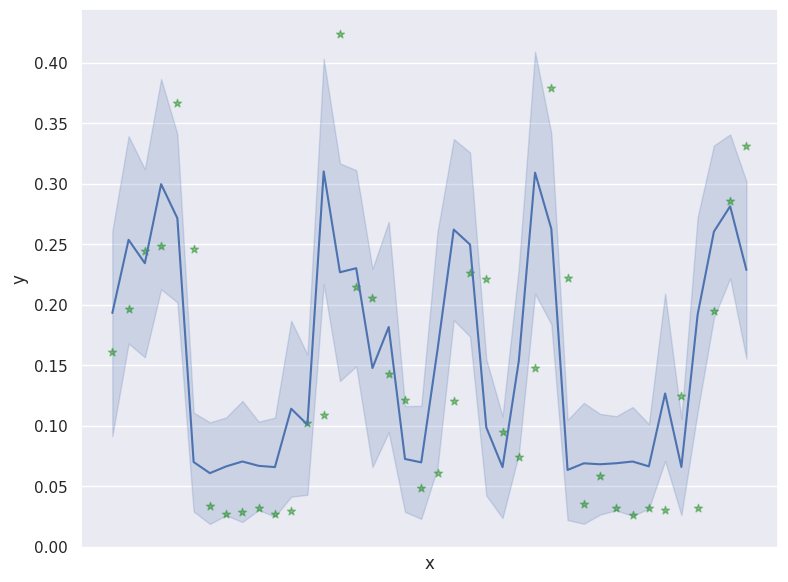

<All keys matched successfully>

In [47]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = 'cpu'
model.to(device)

# patience = patience
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = f'./model_data/mcdo/best_model_mcdo_data_type_{data_type}_{data_version}.pt'

for epoch in range(epochs):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)
            out = model(x)
            val_loss = criterion(y, out)
            val_losses.append(val_loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)

    # Early stopping and model saving logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the model state
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

    print(f'Epoch: {epoch}|Train Loss: {loss}|Val Loss: {avg_val_loss}')
# After training, load the best model

    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].to(device)

                # Sample MC Dropout predictions
                outs = []
                for i in range(10):
                    out = model(x)
                    outs.append(out)

                # Take mean prediction
                out = sum(outs)/len(outs)
                all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_mcdo(model, data_type, epoch,50)

model.load_state_dict(torch.load(best_model_path))  


Epoch 0 | batch train loss: 0.0037156676407903433 | test loss: 0.007916347632245154


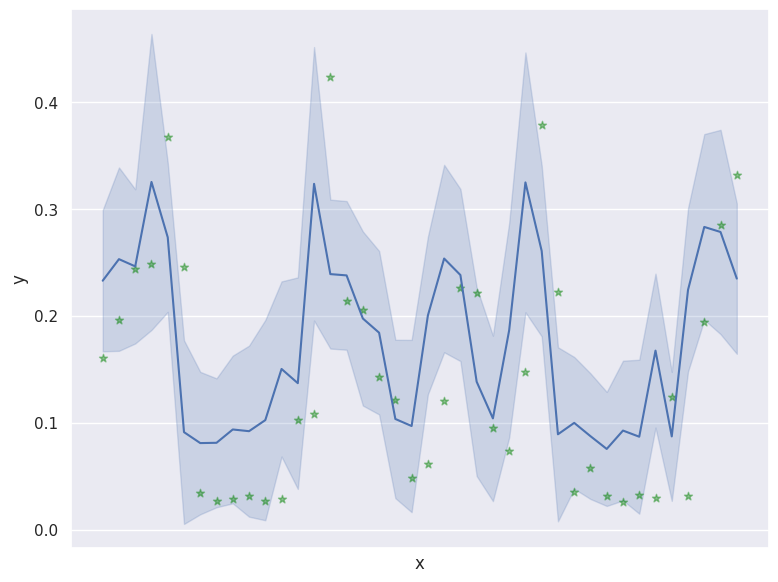

In [21]:
if epoch-1 % 10 != 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].to(device)

                # Sample MC Dropout predictions
                outs = []
                for i in range(10):
                    out = model(x)
                    outs.append(out)

                # Take mean prediction
                out = sum(outs)/len(outs)
                all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_mcdo(model,data_type, epoch,50)

In [27]:
def get_mcdo_results(model,data_set,y_true,type,data_type):
    samples = 50

    preds = [model(data_set) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()

    y_pred = means
    y_true = np.array(y_true)

    # Calculate MSE
    mse = mean_squared_error(y_true, y_pred)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Create a dictionary with the metrics and type
    res_dict = {
        'Type': [type],
        'Data Version': [data_type],
        'Model': 'MCDO',
        'MSE': [mse],
        'RMSE': [rmse],
        'MAE': [mae]
    }

    # Create a pandas DataFrame row
    df_row = pd.DataFrame(res_dict)

    return df_row

df_res = []

df_res.append(get_mcdo_results(model,tensor_train_data, tensor_train_label,'train',data_type))
df_res.append(get_mcdo_results(model,tensor_val_data, tensor_val_label,'val',data_type))
df_res.append(get_mcdo_results(model,tensor_test_data, tensor_test_label,'test',data_type))

df_res = pd.concat(df_res).reset_index(drop=True)

df_res.to_csv(f'./results/{data_version}/results_mcdo_{data_type}_{data_version}.csv')

### Deep Ensemble Model 

In [74]:
import pandas as pd

def get_de_hyperparameters(data_type):
    hp_search_data_path =f'./hyperparameter_search/RAY_RESULTS_de_data{data_type}.csv'
    hp_df = pd.read_csv(hp_search_data_path)

    hp_df = hp_df.sort_values('best_val_loss')
    hp_df.columns = hp_df.columns.str.replace('config/', '')

    return int(hp_df['batch_size'].iloc[0]), int(hp_df['hidden_size'].iloc[0]), int(hp_df['num_layers'].iloc[0]), hp_df['lr'].iloc[0], int(hp_df['patience'].iloc[0]), hp_df['epochs'].iloc[0]

In [75]:
batch_size, hidden_size, num_layers, learning_rate, patience, epochs = get_de_hyperparameters(data_type)
print(batch_size, hidden_size, num_layers, learning_rate, patience, epochs)
num_models =  5

1 80 2 0.0008800402316011 18 200


In [76]:
train_dataset = TensorDataset(tensor_train_data, tensor_train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(tensor_val_data, tensor_val_label)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(tensor_test_data, tensor_test_label)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [77]:
class DeepEnsembleNet(nn.Module):
    def __init__(self, num_features, hidden_size, n_layers):
        super(DeepEnsembleNet, self).__init__()

        layers = []
        input_size = num_features

        # Create 'n' hidden layers
        for _ in range(n_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size  # The output of each layer is the input to the next

        self.layers = nn.ModuleList(layers)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        mu = self.mu(x)
        var = torch.exp(self.var(x))
        return mu, var

model = DeepEnsembleNet(num_features,hidden_size, num_layers)
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

DeepEnsembleNet(
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=80, bias=True)
  )
  (mu): Linear(in_features=80, out_features=1, bias=True)
  (var): Linear(in_features=80, out_features=1, bias=True)
)
Params: 7282


In [78]:
def make_plot_de(model,data_type,epoch):
    num_data_points = 40

    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_test_data)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_test_data.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      temp['x'] = feature_x[train_x.shape[0]+val_x.shape[0]:train_x.shape[0]+val_x.shape[0]+test_x.shape[0]].str_dt.reset_index(drop=True)
      temp = temp[:num_data_points]
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

  #   start = train_df.Input1.min()
  #   end = train_df.Input1.max()

  # # Highligh training range
  #   plt.axvline(x=start)
  #   plt.axvline(x=end)

    # Plot train data on top

    inp_x = feature_x[train_x.shape[0]+val_x.shape[0]:train_x.shape[0]+val_x.shape[0]+test_x.shape[0]].str_dt[:num_data_points]
    inp_y = test_y[:num_data_points]
    # plt.xticks(rotation=-60)
    # Remove x-axis labels and set custom numeric labels
    plt.xticks([])  # Remove x-axis labels
    # plt.gca().set_xticks(range(1, num_data_points + 1))  # Set custom numeric labels

    scatter(inp_x, inp_y, c="green", marker="*", alpha=0.4)

    op_dir = f'./results/{data_version}'
    pathlib.Path(op_dir).mkdir(parents=True, exist_ok=True) 

    output_path = f'{op_dir}/data{data_type}_de_epoch{epoch}_{data_version}.png'
    plt.savefig(output_path)
    plt.show()

In [79]:
# Construct ensemble
# num_models = 5
device = 'cpu'
deep_ensemble = [DeepEnsembleNet(num_features,hidden_size, num_layers).to(device) for i in range(num_models)]
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizers = [optim.Adam(m.parameters(), lr=learning_rate) for m in deep_ensemble]

Epoch: 0|Train Loss: -1.889440393447876|Val Loss: -1.8950178736666021
Epoch 0 | batch train loss: -1.889440393447876 | test loss: -1.9181774522199933


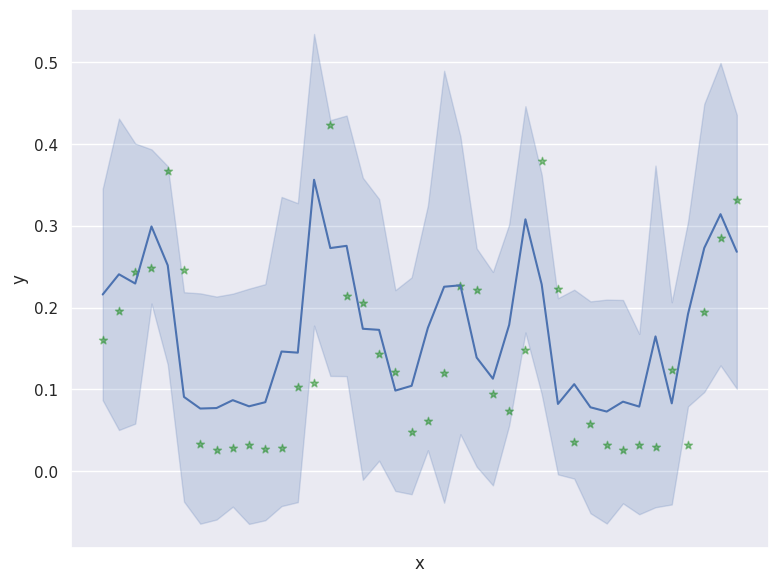

<All keys matched successfully>

In [80]:
# Early stopping parameters
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = f'./model_data/deep_ensemble/best_model_de_data_type_{data_type}.pt'

for epoch in range(epochs):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()

            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    # Validation loop to monitor early stopping
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    for batch in val_loader:  # Assuming you have a validation data loader
        x = batch[0].to(device)
        y = batch[1].to(device)

        with torch.no_grad():  # No gradient calculation for validation data
            for model in deep_ensemble:
                mu, var = model(x)
                val_loss = criterion(mu, y, var)
                val_losses.append(val_loss.item())
    avg_val_loss = sum(val_losses) / len(val_losses)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered at epoch {epoch}')
            break

    print(f'Epoch: {epoch}|Train Loss: {loss}|Val Loss: {avg_val_loss}')

    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_de(deep_ensemble,data_type,epoch)

# After training, load the best model
model.load_state_dict(torch.load(best_model_path))

Epoch 0 | batch train loss: -1.889440393447876 | test loss: -1.9181774522199955


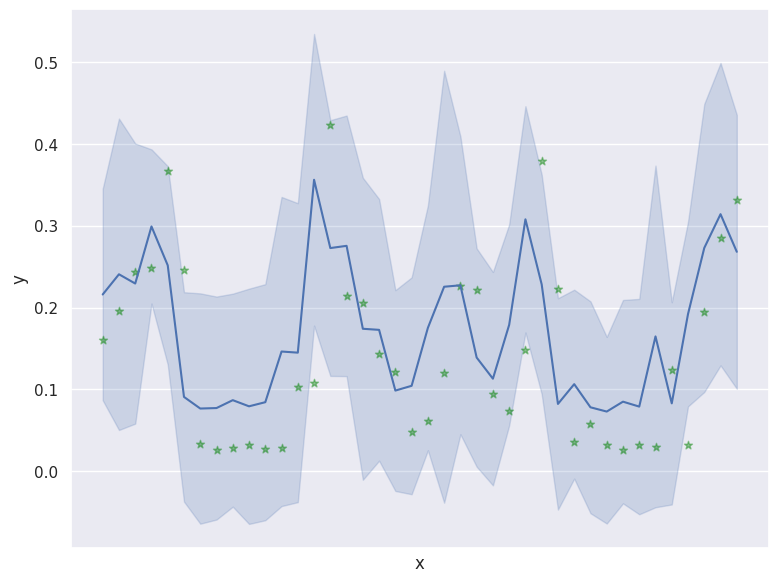

In [81]:

all_test_losses = []
# Test loop
for batch in test_loader:
    x = batch[0].to(device)
    y = batch[1].to(device)

    test_losses = []
    mus = []
    vars = []
    for i, model in enumerate(deep_ensemble):
        optimizers[i].zero_grad()
        mu, var = model(x)
        test_loss = criterion(mu, y, var)
        optimizers[i].step()

        test_losses.append(test_loss.item())
        mus.append(mu)
        vars.append(var)
    all_test_losses.append((sum(test_losses)/len(test_losses)))
test_loss = sum(all_test_losses)/len(all_test_losses)
print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
make_plot_de(deep_ensemble,data_type,epoch)

In [102]:
def get_deep_ensemble_results(model,data_set,y_true,type,data_type):
    mus = []
    vars = []
    for m in model:
        mu, var = m(data_set)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    y_pred = means
    y_true = np.array(y_true)

    # Calculate MSE
    mse = mean_squared_error(y_true, y_pred)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Create a dictionary with the metrics and type
    res_dict = {
        'Type': [type],
        'Data Version': [data_type],
        'Model': 'Deep Ensemble',
        'MSE': [mse],
        'RMSE': [rmse],
        'MAE': [mae]
    }

    # Create a pandas DataFrame row
    df_row = pd.DataFrame(res_dict)

    return df_row

df_res = []

df_res.append(get_deep_ensemble_results(deep_ensemble,tensor_train_data, tensor_train_label,'train',data_type))
df_res.append(get_deep_ensemble_results(deep_ensemble,tensor_val_data, tensor_val_label,'val',data_type))
df_res.append(get_deep_ensemble_results(deep_ensemble,tensor_test_data, tensor_test_label,'test',data_type))

df_res = pd.concat(df_res).reset_index(drop=True)

df_res.to_csv(f'./results/{data_version}/results_deep_ensemble_{data_type}_{data_version}.csv')